In [49]:
# Allow display of images
from IPython.display import display, Image

# Import the required modules
import numpy as np
import matplotlib.pyplot as plt
import glob
from scipy.interpolate import InterpolatedUnivariateSpline
from scipy import signal 
import pandas as pd

# Tools for statistics
from scipy import stats
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn import cluster
from statsmodels.formula.api import ols
from scipy.stats import ttest_1samp, wilcoxon, ttest_ind,mannwhitneyu
import seaborn as sns


# Tools from brainsignal library
import os
import sys
path=r'C:\Users\Hamon\Documents\Stage\brainsignal'
sys.path.append(path)
import brainsignal.datageneration as dg
import brainsignal.datanalysis as da
import brainsignal.postprocessing as pp

# This makes the plots appear inside the notebook
%matplotlib inline

# Load data

### ABP data

In [50]:
rep='../output/'
patientdir='ID_5'
study_name='widow5min'
file=glob.glob(rep+patientdir+study_name+'ABP.txt', recursive=True)[0]

ABPdata=pd.read_csv(file, decimal='.', delimiter='\t')
ABPdata=ABPdata.dropna(axis='columns')

In [51]:
ABPdata

#time  Number of corrected RRi  Heart frequency (Hz)  Power hr (ms2)  \
0      180.0                     20.0                 1.293    2.244000e+10   
1      240.0                     18.0                 1.293    1.163000e+10   
2      300.0                     20.0                 1.280    1.033000e+10   
3      360.0                     18.0                 1.280    1.157000e+10   
4      420.0                     16.0                 1.290    1.183000e+10   
..       ...                      ...                   ...             ...   
907  61380.0                      5.0                 1.253    2.192000e+10   
908  61440.0                      7.0                 1.253    1.211000e+10   
909  61500.0                      7.0                 1.263    1.556000e+10   
910  61560.0                     11.0                 1.263    2.134000e+10   
911  61620.0                     12.0                 1.267    1.252000e+10   

     Power hr integrated (ms2)  Mean ABP (mmHg)  STD ABP (mmHg)  Psys (mmHg)  \
0                  358800000.0            81.07           19.70        118.0   
1                  336300000.0            80.97           19.57        117.7   
2                  338900000.0            85.26           39.27        117.0   
3                  493800000.0            85.64           39.38        119.7   
4                  865200000.0            86.53           39.45        122.8   
..                         ...              ...             ...          ...   
907                498000000.0            89.95           23.44        142.2   
908                450900000.0            90.03           23.47        142.5   
909                437900000.0            89.01           22.83        140.2   
910                437100000.0            90.29           21.82        136.1   
911                340100000.0            91.47           22.13        138.2   

     Pdia (mmHg)  Psys STD (mmHg)  ...  Power LF (ms2)  Power HF (ms2)  \
0          58.81            4.975  ...           21.72           33.18   
1          58.58            4.354  ...           41.97           71.87   
2          57.84            8.012  ...           40.84           87.11   
3          58.36            9.619  ...          128.40          635.90   
4          58.90            9.701  ...          113.40         1652.00   
..           ...              ...  ...             ...             ...   
907        66.15            5.684  ...           57.29           61.40   
908        66.23            5.777  ...          120.30          104.50   
909        65.83            7.609  ...          105.50          109.20   
910        70.13           12.510  ...          903.30         1950.00   
911        71.10           13.440  ...         3550.00         5127.00   

     Power Total (ms2)    LF/HF  Peak VLF (Hz)  Peak LF (Hz)  Peak HF (Hz)  \
0                79.03  0.65460       0.003343       0.05349        0.2641   
1               174.40  0.58390       0.003343       0.04346        0.2608   
2               192.10  0.46880       0.006686       0.05015        0.2407   
3               812.90  0.20180       0.006686       0.14040        0.2708   
4              1817.00  0.06863       0.003343       0.12370        0.4246   
..                 ...      ...            ...           ...           ...   
907             201.60  0.93290       0.016720       0.04346        0.2641   
908             327.40  1.15200       0.016720       0.06686        0.2474   
909             272.60  0.96560       0.016720       0.06352        0.2474   
910            3111.00  0.46330       0.020060       0.11700        0.2340   
911            9359.00  0.69250       0.003343       0.12040        0.2307   

     Fraction LF (%)  Fraction HF (%)  time normalized  
0             39.560            60.44            15.47  
1             36.870            63.13            15.48  
2             31.920            68.08            15.49  
3             16.790            83.21      

### ICP data

In [52]:
file=glob.glob(rep+patientdir+study_name+'ICP.txt', recursive=True)[0]

ICPdata=pd.read_csv(file, decimal='.', delimiter='\t')
ICPdata=ICPdata.dropna(axis='columns')

In [53]:
ICPdata.columns

Index(['#time', 'Heart frequency (Hz)', 'Power hr (ms2)',
       'Respiratory frequency mean (Hz)', 'Respiratory frequency std (Hz)',
       'Mean ICP (mmHg)', 'STD ICP (mmHg)', 'Mean AMP (mmHg)',
       'STD AMP (mmHg)', 'Mean ICP max (mmHg)', 'STD ICP max (mmHg)',
       'Mean ICP min (mmHg)', 'STD ICP min (mmHg)', 'Slope', 'Error slope',
       'Intercept', 'rvalue', 'pvalue', 'std err', 'time normalized'],
      dtype='object')

In [54]:
ICPdata=ICPdata.rename(columns={'Heart frequency (Hz)': 'Heart frequency ICP (Hz)', 'pvalue':'pvalueAMPICP'})

# Transfer functions

In [55]:
file=glob.glob(rep+patientdir+study_name+'TFmag.txt', recursive=True)[0]

TFmagdata=pd.read_csv(file, decimal='.', delimiter='\t')
TFmagdata=TFmagdata.dropna(axis='columns')

In [56]:
TFmagdata

#time/frequency   0.195312   0.390625   0.585938   0.781250   0.976562  \
0            0.058333 -27.243723 -22.414187 -16.691820 -15.721778 -21.078611   
1            0.075000  -5.725233  -5.465482  -1.232802  -4.703522 -18.940255   
2            0.091667  -5.826590  -2.535565   0.651294  -3.147302 -18.738302   
3            0.108333 -45.027845 -47.073216 -38.642418 -39.026533 -34.677207   
4            0.125000 -45.507175 -46.719596 -39.238425 -36.939799 -33.192880   
...               ...        ...        ...        ...        ...        ...   
1020        17.058333 -10.362338  -8.657469 -14.136442 -18.114425 -20.323850   
1021        17.075000  -9.546624  -7.086273  -6.836632 -13.363609 -21.190747   
1022        17.091667  -7.481170  -4.728701  -4.263880 -10.584922 -19.864571   
1023        17.108333  -7.260005  -4.388060  -2.880054  -8.071792 -20.148580   
1024        17.125000  -8.075503  -5.340904  -3.918856  -8.533526 -19.534238   

       1.171875   1.367188   1.562500   1.757812  ...  18.164062  18.359375  \
0    -21.374251 -21.186851 -20.992060 -18.225514  ... -26.078095 -30.320204   
1    -21.014097 -21.065921 -21.431917 -16.789834  ... -24.835289 -28.182821   
2    -20.570557 -20.535983 -20.094615 -13.282886  ... -25.260304 -28.911705   
3    -22.731981 -23.154702 -34.930839 -45.906299  ... -40.780859 -45.062439   
4    -23.583853 -23.163089 -33.560654 -53.551660  ... -48.215159 -52.787559   
...         ...        ...        ...        ...  ...        ...        ...   
1020 -21.023241 -21.246319 -21.716967 -22.871932  ... -42.525447 -36.519920   
1021 -21.090664 -21.145122 -21.393907 -20.833378  ... -36.981635 -34.976315   
1022 -20.849225 -20.922099 -20.831435 -19.383181  ... -45.993075 -38.008691   
1023 -20.608395 -20.440201 -19.971888 -21.042934  ... -43.544718 -40.754016   
1024 -20.631493 -20.510041 -20.355123 -22.652139  ... -50.688157 -41.548495   

      18.554688  18.750000  18.945312  19.140625  19.335938  19.531250  \
0    -32.779872 -33.984398 -40.209073 -35.383717 -34.180392 -36.179864   
1    -30.116681 -33.927632 -33.291709 -32.162635 -31.863658 -31.942038   
2    -31.670363 -35.500845 -33.961770 -31.549822 -30.235807 -32.644248   
3    -49.454754 -61.282899 -51.372792 -54.666578 -47.528198 -46.965681   
4    -61.452612 -63.040276 -52.012557 -53.421149 -50.440119 -51.303060   
...         ...        ...        ...        ...        ...        ...   
1020 -33.989108 -35.382090 -38.536045 -39.839745 -37.424176 -42.751957   
1021 -34.281485 -36.450954 -40.756431 -43.486011 -43.363993 -43.520036   
1022 -35.540147 -36.101360 -39.018684 -42.326120 -43.216797 -39.708703   
1023 -47.889014 -41.349368 -42.948494 -46.045091 -43.202242 -45.243169   
1024 -43.463000 -49.880818 -49.217271 -53.334003 -54.304311 -43.007915   

      19.726562  19.921875  
0    -44.134119 -39.590110  
1    -36.701868 -41.552447  
2    -38.381547 -44.707320  
3    -48.750191 -47.056075  
4    -48.575399 -50.974582  
...         ...        ...  
1020 -33.044384 -30.214435  
1021 -34.770590 -32.096868  
1022 -31.273362 -30.969347  
1023 -47.380566 -41.409447  
1024 -42.162830 -41.095454  

[1025 rows x 103 columns]

# ABP ICP

In [57]:
file=glob.glob(rep+patientdir+study_name+'ABP_ICP.txt', recursive=True)[0]

ABPICPdata=pd.read_csv(file, decimal='.', delimiter='\t')
ABPICPdata=ABPICPdata.dropna(axis='columns')

In [58]:
ABPICPdata

#time  Correlation  pvalue  CPP mean  CPP std
0       180.0       0.4218     0.0     78.87    18.69
1       240.0       0.4523     0.0     78.45    18.47
2       300.0       0.2225     0.0     82.47    38.74
3       360.0       0.2394     0.0     83.24    38.83
4       420.0       0.2918     0.0     84.50    38.87
...       ...          ...     ...       ...      ...
1020  61380.0       0.6461     0.0     84.48    21.94
1021  61440.0       0.6726     0.0     84.85    21.98
1022  61500.0       0.4115     0.0     83.17    21.60
1023  61560.0       0.3306     0.0     83.81    20.82
1024  61620.0       0.3173     0.0     84.88    21.19

[1025 rows x 5 columns]

In [59]:
TFmagdata['#time/frequency']

0        0.058333
1        0.075000
2        0.091667
3        0.108333
4        0.125000
          ...    
1020    17.058333
1021    17.075000
1022    17.091667
1023    17.108333
1024    17.125000
Name: #time/frequency, Length: 1025, dtype: float64

### Combine databases

In [60]:
ABPdata

#time  Number of corrected RRi  Heart frequency (Hz)  Power hr (ms2)  \
0      180.0                     20.0                 1.293    2.244000e+10   
1      240.0                     18.0                 1.293    1.163000e+10   
2      300.0                     20.0                 1.280    1.033000e+10   
3      360.0                     18.0                 1.280    1.157000e+10   
4      420.0                     16.0                 1.290    1.183000e+10   
..       ...                      ...                   ...             ...   
907  61380.0                      5.0                 1.253    2.192000e+10   
908  61440.0                      7.0                 1.253    1.211000e+10   
909  61500.0                      7.0                 1.263    1.556000e+10   
910  61560.0                     11.0                 1.263    2.134000e+10   
911  61620.0                     12.0                 1.267    1.252000e+10   

     Power hr integrated (ms2)  Mean ABP (mmHg)  STD ABP (mmHg)  Psys (mmHg)  \
0                  358800000.0            81.07           19.70        118.0   
1                  336300000.0            80.97           19.57        117.7   
2                  338900000.0            85.26           39.27        117.0   
3                  493800000.0            85.64           39.38        119.7   
4                  865200000.0            86.53           39.45        122.8   
..                         ...              ...             ...          ...   
907                498000000.0            89.95           23.44        142.2   
908                450900000.0            90.03           23.47        142.5   
909                437900000.0            89.01           22.83        140.2   
910                437100000.0            90.29           21.82        136.1   
911                340100000.0            91.47           22.13        138.2   

     Pdia (mmHg)  Psys STD (mmHg)  ...  Power LF (ms2)  Power HF (ms2)  \
0          58.81            4.975  ...           21.72           33.18   
1          58.58            4.354  ...           41.97           71.87   
2          57.84            8.012  ...           40.84           87.11   
3          58.36            9.619  ...          128.40          635.90   
4          58.90            9.701  ...          113.40         1652.00   
..           ...              ...  ...             ...             ...   
907        66.15            5.684  ...           57.29           61.40   
908        66.23            5.777  ...          120.30          104.50   
909        65.83            7.609  ...          105.50          109.20   
910        70.13           12.510  ...          903.30         1950.00   
911        71.10           13.440  ...         3550.00         5127.00   

     Power Total (ms2)    LF/HF  Peak VLF (Hz)  Peak LF (Hz)  Peak HF (Hz)  \
0                79.03  0.65460       0.003343       0.05349        0.2641   
1               174.40  0.58390       0.003343       0.04346        0.2608   
2               192.10  0.46880       0.006686       0.05015        0.2407   
3               812.90  0.20180       0.006686       0.14040        0.2708   
4              1817.00  0.06863       0.003343       0.12370        0.4246   
..                 ...      ...            ...           ...           ...   
907             201.60  0.93290       0.016720       0.04346        0.2641   
908             327.40  1.15200       0.016720       0.06686        0.2474   
909             272.60  0.96560       0.016720       0.06352        0.2474   
910            3111.00  0.46330       0.020060       0.11700        0.2340   
911            9359.00  0.69250       0.003343       0.12040        0.2307   

     Fraction LF (%)  Fraction HF (%)  time normalized  
0             39.560            60.44            15.47  
1             36.870            63.13            15.48  
2             31.920            68.08            15.49  
3             16.790            83.21      

In [61]:
TFmagdata['#time']=round(TFmagdata['#time/frequency']*60*60)-30

### Here it would be nice to have the same times directly in the output file

In [62]:
ABPICPdata

#time  Correlation  pvalue  CPP mean  CPP std
0       180.0       0.4218     0.0     78.87    18.69
1       240.0       0.4523     0.0     78.45    18.47
2       300.0       0.2225     0.0     82.47    38.74
3       360.0       0.2394     0.0     83.24    38.83
4       420.0       0.2918     0.0     84.50    38.87
...       ...          ...     ...       ...      ...
1020  61380.0       0.6461     0.0     84.48    21.94
1021  61440.0       0.6726     0.0     84.85    21.98
1022  61500.0       0.4115     0.0     83.17    21.60
1023  61560.0       0.3306     0.0     83.81    20.82
1024  61620.0       0.3173     0.0     84.88    21.19

[1025 rows x 5 columns]

In [63]:
tini=max((ICPdata['#time'][0],ABPdata['#time'][0],TFmagdata['#time'][0]))

tend=min((max(ICPdata['#time']),max(ABPdata['#time']),max(TFmagdata['#time'])))


In [64]:
data=ICPdata.merge(ABPdata,on='#time')
data=data.merge(ABPICPdata,on='#time')
data=data.merge(TFmagdata,on='#time')

In [ ]:
Il y a un probleme dans les temps ici.

In [65]:
ICPdata

#time  Heart frequency ICP (Hz)  Power hr (ms2)  \
0       280.0                  1.291987     134600000.0   
1       340.0                  1.279987      98680000.0   
2       400.0                  1.251987     114400000.0   
3       460.0                  1.251987     120700000.0   
4       520.0                  1.249988      87720000.0   
...       ...                       ...             ...   
1016  61240.0                  1.251987      96160000.0   
1017  61300.0                  1.251987     143300000.0   
1018  61360.0                  1.253987     162200000.0   
1019  61420.0                  1.253987     162100000.0   
1020  61480.0                  1.265987     110700000.0   

      Respiratory frequency mean (Hz)  Respiratory frequency std (Hz)  \
0                            0.226705                        0.034239   
1                            0.270383                        0.057489   
2                            0.264143                        0.080419   
3                            0.226705                        0.033213   
4                            0.212146                        0.036973   
...                               ...                             ...   
1016                         0.237105                        0.039681   
1017                         0.253744                        0.038799   
1018                         0.259983                        0.038966   
1019                         0.235025                        0.043578   
1020                         0.247504                        0.059667   

      Mean ICP (mmHg)  STD ICP (mmHg)  Mean AMP (mmHg)  STD AMP (mmHg)  \
0               2.144           2.588            4.834          1.0450   
1               2.213           2.552            4.855          1.0360   
2               2.345           2.580            4.995          1.0700   
3               2.252           2.503            4.938          1.0260   
4               2.080           2.201            4.851          0.8368   
...               ...             ...              ...             ...   
1016            5.232           3.076            5.508          0.9298   
1017            5.242           3.009            5.503          0.9577   
1018            5.093           2.492            5.514          0.9202   
1019            5.980           3.555            5.667          0.9190   
1020            6.223           3.519            5.794          1.0280   

      Mean ICP max (mmHg)  STD ICP max (mmHg)  Mean ICP min (mmHg)  \
0                   4.657               2.551              -0.3562   
1                   4.721               2.519              -0.3076   
2                   4.894               2.539              -0.2235   
3                   4.777               2.434              -0.3116   
4                   4.568               1.852              -0.4045   
...                   ...                 ...                  ...   
1016                7.961               2.919               2.3540   
1017                7.968               2.874               2.3560   
1018                7.808               2.255               2.2230   
1019                8.827               3.594               2.9350   
1020                9.131               3.508               3.1420   

      STD ICP min (mmHg)   Slope  Error slope  Intercept  rvalue  \
0                  1.159  0.6247        11.26      5.026  0.6300   
1                  1.125  0.6323        10.44      5.009  0.6536   
2                  1.115  0.6514        10.65      5.056  0.6455   
3                  1.055  0.6320        11.05      5.059  0.6263   
4                  1.027  0.5471        10.02      5.061  0.6431   
...                  ...     ...          ...        ...     ...   
1016               2.056  0.3328        12.65      4.787  0.3595   
1017               2.042  0.3548        12.84      4.729  0.3727   
1018               1.343  0.4447        11.40      4.488  0.4709   
1019        

In [66]:
ABPdata

#time  Number of corrected RRi  Heart frequency (Hz)  Power hr (ms2)  \
0      180.0                     20.0                 1.293    2.244000e+10   
1      240.0                     18.0                 1.293    1.163000e+10   
2      300.0                     20.0                 1.280    1.033000e+10   
3      360.0                     18.0                 1.280    1.157000e+10   
4      420.0                     16.0                 1.290    1.183000e+10   
..       ...                      ...                   ...             ...   
907  61380.0                      5.0                 1.253    2.192000e+10   
908  61440.0                      7.0                 1.253    1.211000e+10   
909  61500.0                      7.0                 1.263    1.556000e+10   
910  61560.0                     11.0                 1.263    2.134000e+10   
911  61620.0                     12.0                 1.267    1.252000e+10   

     Power hr integrated (ms2)  Mean ABP (mmHg)  STD ABP (mmHg)  Psys (mmHg)  \
0                  358800000.0            81.07           19.70        118.0   
1                  336300000.0            80.97           19.57        117.7   
2                  338900000.0            85.26           39.27        117.0   
3                  493800000.0            85.64           39.38        119.7   
4                  865200000.0            86.53           39.45        122.8   
..                         ...              ...             ...          ...   
907                498000000.0            89.95           23.44        142.2   
908                450900000.0            90.03           23.47        142.5   
909                437900000.0            89.01           22.83        140.2   
910                437100000.0            90.29           21.82        136.1   
911                340100000.0            91.47           22.13        138.2   

     Pdia (mmHg)  Psys STD (mmHg)  ...  Power LF (ms2)  Power HF (ms2)  \
0          58.81            4.975  ...           21.72           33.18   
1          58.58            4.354  ...           41.97           71.87   
2          57.84            8.012  ...           40.84           87.11   
3          58.36            9.619  ...          128.40          635.90   
4          58.90            9.701  ...          113.40         1652.00   
..           ...              ...  ...             ...             ...   
907        66.15            5.684  ...           57.29           61.40   
908        66.23            5.777  ...          120.30          104.50   
909        65.83            7.609  ...          105.50          109.20   
910        70.13           12.510  ...          903.30         1950.00   
911        71.10           13.440  ...         3550.00         5127.00   

     Power Total (ms2)    LF/HF  Peak VLF (Hz)  Peak LF (Hz)  Peak HF (Hz)  \
0                79.03  0.65460       0.003343       0.05349        0.2641   
1               174.40  0.58390       0.003343       0.04346        0.2608   
2               192.10  0.46880       0.006686       0.05015        0.2407   
3               812.90  0.20180       0.006686       0.14040        0.2708   
4              1817.00  0.06863       0.003343       0.12370        0.4246   
..                 ...      ...            ...           ...           ...   
907             201.60  0.93290       0.016720       0.04346        0.2641   
908             327.40  1.15200       0.016720       0.06686        0.2474   
909             272.60  0.96560       0.016720       0.06352        0.2474   
910            3111.00  0.46330       0.020060       0.11700        0.2340   
911            9359.00  0.69250       0.003343       0.12040        0.2307   

     Fraction LF (%)  Fraction HF (%)  time normalized  
0             39.560            60.44            15.47  
1             36.870            63.13            15.48  
2             31.920            68.08            15.49  
3             16.790            83.21      

# Data filtering

In [67]:
data['errABPABP']=np.abs(data['Heart frequency (Hz)']-(1/(data['Mean RR (ms)']*1e-3)))/data['Heart frequency (Hz)']*100

In [68]:
data['errABPICP']=np.abs(data['Heart frequency ICP (Hz)']-data['Heart frequency (Hz)'])/data['Heart frequency ICP (Hz)']*100

In [69]:
data

Empty DataFrame
Columns: [Heart frequency ICP (Hz), Power hr (ms2)_x, Respiratory frequency mean (Hz), Respiratory frequency std (Hz), Mean ICP (mmHg), STD ICP (mmHg), Mean AMP (mmHg), STD AMP (mmHg), Mean ICP max (mmHg), STD ICP max (mmHg), Mean ICP min (mmHg), STD ICP min (mmHg), Slope, Error slope, Intercept, rvalue, pvalueAMPICP, std err, time normalized_x, Number of corrected RRi, Heart frequency (Hz), Power hr (ms2)_y, Power hr integrated (ms2), Mean ABP (mmHg), STD ABP (mmHg), Psys (mmHg), Pdia (mmHg), Psys STD (mmHg), Pdia STD (mmHg), Psys max (mmHg), Pdia max (mmHg), Psys min (mmHg), Pdia min (mmHg), Psys outliers, Pdia outliers, Mean RR (ms), STD RR (ms), Min RR (ms), Max RR (ms), RMSSD (ms), NNxx, pNNxx (%), CVSD, range_nni (ms), Sample entropy, Power VLF (ms2), Power LF (ms2), Power HF (ms2), Power Total (ms2), LF/HF, Peak VLF (Hz), Peak LF (Hz), Peak HF (Hz), Fraction LF (%), Fraction HF (%), time normalized_y, Correlation, pvalue, CPP mean, CPP std, #time/frequency, 0.195312, 0.390625, 0.585938, 0.781250, 0.976562, 1.171875, 1.367188, 1.562500, 1.757812, 1.953125, 2.148438, 2.343750, 2.539062, 2.734375, 2.929688, 3.125000, 3.320312, 3.515625, 3.710938, 3.906250, 4.101562, 4.296875, 4.492188, 4.687500, 4.882812, 5.078125, 5.273438, 5.468750, 5.664062, 5.859375, 6.054688, 6.250000, 6.445312, 6.640625, 6.835938, 7.031250, 7.226562, 7.421875, 7.617188, ...]
Index: []

[0 rows x 166 columns]

### filtering on discrepency between Heart rate measurments

<AxesSubplot:>

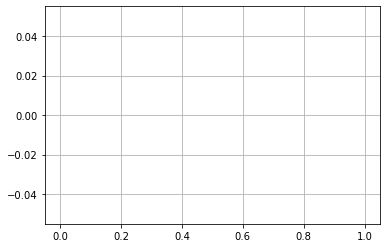

In [40]:
Igood=data['errABPABP']<=10
(abs(data['errABPABP'])).hist()
(abs(data['errABPABP']))[Igood].hist()

<AxesSubplot:>

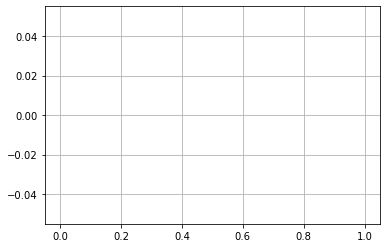

In [41]:
Igood=Igood&(data['errABPICP']<=10)
(abs(data['errABPICP'])).hist()
(abs(data['errABPICP']))[Igood].hist()

In [42]:
#Igood=Igood&(ABPdata['STD RR (ms)']<120)

#ABPdata['STD RR (ms)'].hist()
#ABPdata['STD RR (ms)'][Igood].hist()

### filtering on difference between mean ABP pressures and extrema

<AxesSubplot:>

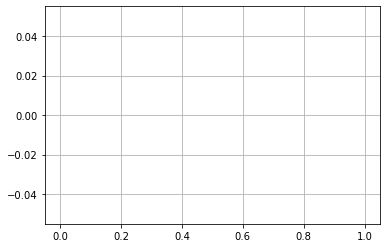

In [43]:
#Igood=Igood&(abs(ABPdata['Pdia (mmHg)']-ABPdata['Pdia max (mmHg)'])<50)
#Igood=Igood&(abs(ABPdata['Pdia (mmHg)']-ABPdata['Pdia min (mmHg)'])<50)


(abs(data['Pdia (mmHg)']-data['Pdia min (mmHg)']))[Igood].hist()

<AxesSubplot:>

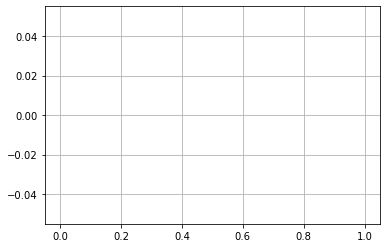

In [44]:
#Igood=Igood&(abs(ABPdata['Psys (mmHg)']-ABPdata['Psys max (mmHg)'])<80)
#Igood=Igood&(abs(ABPdata['Psys (mmHg)']-ABPdata['Psys min (mmHg)'])<80)

(abs(data['Psys (mmHg)']-data['Psys min (mmHg)']))[Igood].hist()

<AxesSubplot:>

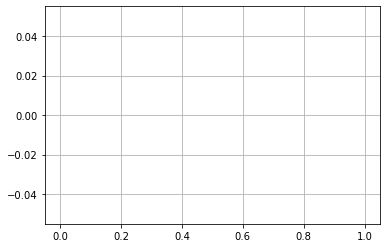

In [45]:
data['STD RR (ms)'][Igood].hist()

In [46]:
data=data.dropna()
data=data[Igood]

# Correlations analysis

### ABP ICP correlation

Concept and definition of the pressure reactivity index (PRx).

A: In patients with impaired cerebral autoregulation, a vicious cycle occurs (upper left), and the correlation coefficient (PRx) between MAP and ICP is positively increased (lower). 
    
B: In patients with preserved cerebral autoregulation, a positive cycle is formed by cerebral autoregulation (upper), and the PRx decreases and sometimes becomes negative (lower) (This is modified from reference 10). CBV, cerebral blood volume; MAP, mean arterial pressure; CPP, cerebral perfusion pressure; ICP, intracranial pressure.

[Cho et al.,  J Neurointensive Care, 2018, doi: 10.32587/jnic.2018.00038]

![MAP-ICP](../notebooks/images/MAP-ICP.jpg)

Text(0.5, 1.0, 'ICP (mmHg)')

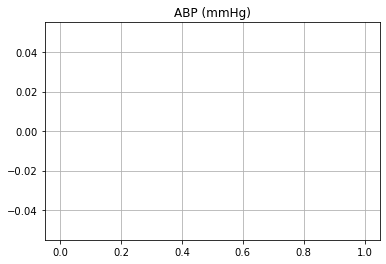

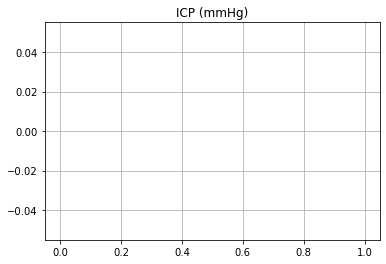

In [47]:
(data['Mean ABP (mmHg)'][Igood]).hist()
plt.title('ABP (mmHg)')

plt.figure()
(data['Mean ICP (mmHg)'][Igood]).hist()
plt.title('ICP (mmHg)')


In [48]:
varx='Mean ICP (mmHg)'
vary='Mean ABP (mmHg)'

#remove the outliers in ICP
#filter=data['Mean ICP (mmHg)']<=15
dataplot=data#[filter]


x=dataplot[varx]
y=dataplot[vary]
nas = np.logical_or(pd.isnull(x), pd.isnull(y))
r, p = stats.pearsonr(x[~nas], y[~nas]) #pearsonr
l1='r=%.2f,p=%.2f'%(r,p)


fig, ax = plt.subplots()
g=sns.regplot(data=dataplot,x=varx,y=vary,ax=ax)
L=[l1]
plt.legend(L)

ValueError: x and y must have length at least 2.

In [ ]:
varx='Mean ICP (mmHg)'
vary='Mean ABP (mmHg)'

#remove the outliers in ICP
filter=data['Mean ICP (mmHg)']<=15


#separate in two groups for ABP dia , threasold = 75 mmHg

# group 1 
filter1=filter&(data['Mean ABP (mmHg)']<=100)

dataplot=data[filter1]

x=dataplot[varx]
y=dataplot[vary]
nas = np.logical_or(pd.isnull(x), pd.isnull(y))
r, p = stats.pearsonr(x[~nas], y[~nas])

l1='r=%.2f,p=%.2f'%(r,p)

fig, ax = plt.subplots()
g=sns.regplot(data=dataplot,x=varx,y=vary,ax=ax)

# group 2
filter2=filter&(data['Mean ABP (mmHg)']>100)

dataplot=data[filter2]


x=dataplot[varx]
y=dataplot[vary]
nas = np.logical_or(pd.isnull(x), pd.isnull(y))
r, p = stats.pearsonr(x[~nas], y[~nas])

l2='r=%.2f,p=%.2f'%(r,p)

g=sns.regplot(data=dataplot,x=varx,y=vary,ax=ax)


L=[l1, l2]
plt.legend(L)

In [ ]:
varx='Mean ICP min (mmHg)'
vary='Pdia (mmHg)'

#remove the outliers in ICP
#filter=data['Mean ICP (mmHg)']<=15
dataplot=data#[filter]


x=dataplot[varx]
y=dataplot[vary]
nas = np.logical_or(pd.isnull(x), pd.isnull(y))
r, p = stats.pearsonr(x[~nas], y[~nas]) #pearsonr
l1='r=%.2f,p=%.2f'%(r,p)


fig, ax = plt.subplots()
g=sns.regplot(data=dataplot,x=varx,y=vary,ax=ax)
L=[l1]
plt.legend(L)

In [ ]:
varx='Mean ICP max (mmHg)'
vary='Psys (mmHg)'

#remove the outliers in ICP
#filter=data['Mean ICP (mmHg)']<=15
dataplot=data#[filter]


x=dataplot[varx]
y=dataplot[vary]
nas = np.logical_or(pd.isnull(x), pd.isnull(y))
r, p = stats.pearsonr(x[~nas], y[~nas]) #pearsonr
l1='r=%.2f,p=%.2f'%(r,p)


fig, ax = plt.subplots()
g=sns.regplot(data=dataplot,x=varx,y=vary,ax=ax)
L=[l1]
plt.legend(L)

### PRx at 5 minutes time scale

In [ ]:
data['Correlation'].hist()

In [ ]:
plt.scatter(data['Pdia (mmHg)'],data['Correlation'])

Todo : check the definition of PRx. Maybe we need to average the pressure ? I an surprised it is always positive where there were twi trends in the mean ICP mean ABP correlations 

In [ ]:
varx='Mean ICP (mmHg)'
vary='Mean AMP (mmHg)'

#remove the outliers in ICP
filter=data['Mean ICP (mmHg)']<=15
dataplot=data[filter]


x=dataplot[varx]
y=dataplot[vary]
nas = np.logical_or(pd.isnull(x), pd.isnull(y))
r, p = stats.pearsonr(x[~nas], y[~nas]) #pearsonr
l1='r=%.2f,p=%.2f'%(r,p)


fig, ax = plt.subplots()
g=sns.regplot(data=dataplot,x=varx,y=vary,ax=ax)
L=[l1]
plt.legend(L)

It seems that higher is p0 higher is the slope. Why ? Try to understant this with Ursino.

In [ ]:
data['p0']=-data['Intercept']/data['Slope']
data['invp0']=-data['Slope']/data['Intercept']

In [ ]:
data['Slope'].hist()

We can see that the slope can be 0 : there are times where amp ICP and ICP seems not correlated --> need to perfom the analysis on a shorted time window. 
    
I will filter with the p-value

In [ ]:
varx='Slope'
vary='p0'

#remove the outliers in ICP
filter=(data['pvalueAMPICP']<=0.05)&(data['Slope']>=0.1)
dataplot=data[filter]


x=dataplot[varx]
y=dataplot[vary]
nas = np.logical_or(pd.isnull(x), pd.isnull(y))
r, p = stats.pearsonr(x[~nas], y[~nas]) #pearsonr
l1='r=%.2f,p=%.2f'%(r,p)


fig, ax = plt.subplots()
g=sns.regplot(data=dataplot,x=varx,y=vary,ax=ax)
L=[l1]
plt.legend(L)

In [ ]:
varx='Slope'
vary='Intercept'

#remove the outliers in ICP
filter=(data['pvalue']<=0.05)&(data['Slope']>=0.1)
dataplot=data[filter]


x=dataplot[varx]
y=dataplot[vary]
nas = np.logical_or(pd.isnull(x), pd.isnull(y))
r, p = stats.pearsonr(x[~nas], y[~nas]) #pearsonr
l1='r=%.2f,p=%.2f'%(r,p)


fig, ax = plt.subplots()
g=sns.regplot(data=dataplot,x=varx,y=vary,ax=ax)
L=[l1]
plt.legend(L)

### Blood flow and perfusion pressure

I should check the definition of perfusion pressure.

When ABP - ICP is reduced the intracranial blood flow is reduced whereas the resistance is also reduced by vessels dilaiton. --> but then ICP is increased and the difference is evenmore reduced.

If we have an increase in the slope, probably delta V is higher --> the young modulus of arteries as the muscles are less contracted --> the active part is important in the slope and following the slope can give an indication of the contraction / dilation of active walls in the brain.

But then why isnt this visible during the infusion test ? As the ICP increases we are reducing CPP and the vessel should dilate. 

The other eplaination for an increased slope is a less compliant CNS. If the pressure in the veins is increased then the compliance from the equeching of the veins is reduced. Then ICP is increased which is compatible with the reduced CPP. Does a lower slope means and increased veinous pressure ?

In [ ]:
vary='Slope'
varx='CPP mean'

#remove the outliers in ICP
filter=data['Mean ICP (mmHg)']<=15

dataplot=data[filter]

x=dataplot[varx]
y=dataplot[vary]
nas = np.logical_or(pd.isnull(x), pd.isnull(y))
r, p = stats.pearsonr(x[~nas], y[~nas]) #pearsonr
l1='r=%.2f,p=%.2f'%(r,p)

fig, ax = plt.subplots()
g=sns.regplot(data=dataplot,x=varx,y=vary,ax=ax)
L=[l1]
plt.legend(L)

In [ ]:
varx='Slope'
vary='Mean ICP (mmHg)'

#remove the outliers in ICP
filter=data['Mean ICP (mmHg)']<=15
dataplot=data[filter]


x=dataplot[varx]
y=dataplot[vary]
nas = np.logical_or(pd.isnull(x), pd.isnull(y))
r, p = stats.pearsonr(x[~nas], y[~nas]) #pearsonr
l1='r=%.2f,p=%.2f'%(r,p)


fig, ax = plt.subplots()
g=sns.regplot(data=dataplot,x=varx,y=vary,ax=ax)
L=[l1]
plt.legend(L)

In [ ]:
varx='Slope'
vary='Mean ABP (mmHg)'

#remove the outliers in ICP
filter=data['Mean ICP (mmHg)']<=15
dataplot=data[filter]


x=dataplot[varx]
y=dataplot[vary]
nas = np.logical_or(pd.isnull(x), pd.isnull(y))
r, p = stats.pearsonr(x[~nas], y[~nas]) #pearsonr
l1='r=%.2f,p=%.2f'%(r,p)


fig, ax = plt.subplots()
g=sns.regplot(data=dataplot,x=varx,y=vary,ax=ax)
L=[l1]
plt.legend(L)

### ABP and autonomous system

Mean RR is lower for higher P sys. --> heart rate increase with decreased arterial pressure = baroreflex

It seems to be 2 (3) clusters

In [ ]:
vary='Mean RR (ms)'
varx='Psys (mmHg)'


dataplot=data #[filter]

x=dataplot[varx]
y=dataplot[vary]
nas = np.logical_or(pd.isnull(x), pd.isnull(y))
r, p = stats.spearmanr(x[~nas], y[~nas]) #pearsonr
l1='r=%.2f,p=%.2f'%(r,p)

fig, ax = plt.subplots()
g=sns.scatterplot(data=dataplot,x=varx,y=vary,ax=ax)
L=[l1]
plt.legend(L)

In [ ]:
vary='Mean RR (ms)'
varx='Pdia (mmHg)'


dataplot=data #[filter]

x=dataplot[varx]
y=dataplot[vary]
nas = np.logical_or(pd.isnull(x), pd.isnull(y))
r, p = stats.spearmanr(x[~nas], y[~nas]) #pearsonr
l1='r=%.2f,p=%.2f'%(r,p)


fig, ax = plt.subplots()
g=sns.scatterplot(data=dataplot,x=varx,y=vary,ax=ax)
L=[l1]
plt.legend(L)

### ICP and autonomous system

In [ ]:
ABPdata.columns

In [ ]:
ICPdata.columns

In [ ]:
data['Power VLF log']=np.log(data['Power VLF (ms2)'])
data['Power LF log']=np.log(data['Power LF (ms2)'])
data['Power HF log']=np.log(data['Power HF (ms2)'])

In [ ]:
sns.pairplot(data[['Mean RR (ms)', 'RMSSD (ms)', 'NNxx',
       'pNNxx (%)', 'CVSD', 'range_nni (ms)', 'Sample entropy',
       'Power VLF log', 'Power LF log', 'Power HF log']])

In [ ]:
data['Mean RR (ms)'].hist()

In [ ]:
data['Power HF log shift']=np.nan
ishift=0

for i in range(0,len(data['Power HF log shift'])-ishift) :
    data['Power HF log shift'].iloc[i]=data['Power HF log'].iloc[i+ishift]

In [ ]:
I=(data['#time']>tini)&(data['#time']<tend)

var1='Mean ICP (mmHg)'
var2= 'Power HF log shift'

meanAMP_smooth=signal.savgol_filter(data[var1],window_length=19, polyorder=4)
HF_smooth=signal.savgol_filter(data[var2],window_length=19, polyorder=4)

plt.plot(data['#time'][I],data[var1][I],'b.')
plt.plot(data['#time'][I],meanAMP_smooth[I],'b-')

plt.plot(data['#time'][I],data[var2][I],'r.')
plt.plot(data['#time'][I],HF_smooth[I],'r-')

In [ ]:
sns.scatterplot(data=data[I],x=var1,y=var2)

In [ ]:
I=(data['#time']>tini)&(data['#time']<tend)

var1='Mean AMP (mmHg)'
var2= 'Power HF log shift'

meanAMP_smooth=signal.savgol_filter(data[var1],window_length=19, polyorder=4)
HF_smooth=signal.savgol_filter(data[var2],window_length=19, polyorder=4)

plt.plot(data['#time'][I],data[var1][I],'b.')
plt.plot(data['#time'][I],meanAMP_smooth[I],'b-')

plt.plot(data['#time'][I],data[var2][I],'r.')
plt.plot(data['#time'][I],HF_smooth[I],'r-')

In [ ]:
sns.scatterplot(data=data[I],x=var1,y=var2)

In [ ]:
I=(data['#time']>tini)&(data['#time']<tend)

var1='Slope'
var2= 'Power HF log shift'

meanAMP_smooth=signal.savgol_filter(data[var1],window_length=19, polyorder=4)
HF_smooth=signal.savgol_filter(data[var2],window_length=19, polyorder=4)

plt.plot(data['#time'][I],data[var1][I],'b.')
plt.plot(data['#time'][I],meanAMP_smooth[I],'b-')

plt.plot(data['#time'][I],data[var2][I],'r.')
plt.plot(data['#time'][I],HF_smooth[I],'r-')

In [ ]:
sns.scatterplot(data=data[I],x=var1,y=var2)

# Clustering

In [ ]:
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [ ]:
ABPdata.columns

In [ ]:
variables=['STD RR (ms)','RMSSD (ms)', 'NNxx',
       'pNNxx (%)', 'CVSD', 'range_nni (ms)',  'Power VLF log', 'Power LF log', 'Power HF log','LF/HF']

variables=['STD RR (ms)','RMSSD (ms)', 'pNNxx (%)', 'CVSD', 'range_nni (ms)',  'Power VLF log', 'Power LF log', 'Power HF log','LF/HF','Mean RR (ms)','Psys (mmHg)', 'Pdia (mmHg)', 'Psys STD (mmHg)', 'Pdia STD (mmHg)','Respiratory frequency mean (Hz)','Respiratory frequency std (Hz)']

In [ ]:
reduced_data=data[variables]
#reduced_data=reduced_data.dropna()

reduced_data =reduced_data.values


### Normalisation

In [ ]:
reduced_data = scaler.fit_transform(reduced_data)

### PCA

In [ ]:
clf=PCA(n_components=2)
reduced_data = clf.fit_transform((reduced_data))
exp_va=sum(clf.explained_variance_ratio_)

print('Explained variance with PC :', exp_va)

In [ ]:
fig, ax = plt.subplots()    
width = 0.75 # the width of the bars 
ind = np.arange(len(variables))  # the x locations for the groups
ax.barh(ind, (clf.components_[0]), width, color="blue")
ax.set_yticks(ind+width/2)
ax.set_yticklabels(variables, minor=False)

In [ ]:
fig, ax = plt.subplots()    
width = 0.75 # the width of the bars 
ind = np.arange(len(variables))  # the x locations for the groups
ax.barh(ind, (clf.components_[1]), width, color="blue")
ax.set_yticks(ind+width/2)
ax.set_yticklabels(variables, minor=False)

In [ ]:
data['PCA1'] = scaler.fit_transform(reduced_data[:,0].reshape(-1, 1))
data['PCA2'] = scaler.fit_transform(reduced_data[:,1].reshape(-1, 1))

### Manual second component (if wanted)

In [ ]:
ICPdata.columns

In [ ]:
variables=['Mean RR (ms)','Psys (mmHg)', 'Pdia (mmHg)', 'Psys STD (mmHg)', 'Pdia STD (mmHg)','Respiratory frequency mean (Hz)','Respiratory frequency std (Hz)']

In [ ]:
reduced_data=data[variables]
#reduced_data=reduced_data.dropna()

reduced_data =reduced_data.values


### Normalisation

In [ ]:
reduced_data = scaler.fit_transform(reduced_data)

### PCA

In [ ]:
clf=PCA(n_components=1)
reduced_data = clf.fit_transform((reduced_data))
exp_va=sum(clf.explained_variance_ratio_)

print('Explained variance with PC :', exp_va)

In [ ]:
fig, ax = plt.subplots()    
width = 0.75 # the width of the bars 
ind = np.arange(len(variables))  # the x locations for the groups
ax.barh(ind, (clf.components_[0]), width, color="blue")
ax.set_yticks(ind+width/2)
ax.set_yticklabels(variables, minor=False)

In [ ]:
data['PCA2'] = scaler.fit_transform(reduced_data)

### Clustering

In [ ]:
reduced_data=data[['PCA1','PCA2']]

reduced_data =reduced_data.values


In [ ]:
sns.color_palette("Paired",5)

In [ ]:
import matplotlib.cm as cm
import matplotlib as mpl
from matplotlib.colors import ListedColormap
norm = mpl.colors.Normalize(vmin=0, vmax=5)
#cmap = cm.nipy_spectral
cmap = cmap = ListedColormap(sns.color_palette("Paired",5))  
m = cm.ScalarMappable(norm=norm, cmap=cmap)


In [ ]:
from sklearn.cluster import Birch

# define the model
model = Birch(threshold=0.01, n_clusters=5)
# fit model and predict clusters
yhat = model.fit_predict(reduced_data)
# retrieve unique clusters
clusters = np.unique(yhat)

print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(reduced_data, model.labels_, metric='sqeuclidean'))

# create scatter plot for samples from each cluster
for cluster in clusters:
    #get distance to the cluster
    #d = model.transform(reduced_data)[:, cluster]
        
    # get row indexes for samples with this cluster
    row_ix = np.where(yhat == cluster)
    
    # create scatter of these samples
    plt.scatter(reduced_data[row_ix, 0], reduced_data[row_ix, 1],color=m.to_rgba(cluster))

In [ ]:
from sklearn.cluster import AgglomerativeClustering

# define the model
model = AgglomerativeClustering(n_clusters=5)
# fit model and predict clusters
yhat = model.fit_predict(reduced_data)
# retrieve unique clusters
clusters = np.unique(yhat)

print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(reduced_data, model.labels_, metric='sqeuclidean'))

# create scatter plot for samples from each cluster
for cluster in clusters:
    #get distance to the cluster
    #d = model.transform(reduced_data)[:, cluster]
        
    # get row indexes for samples with this cluster
    row_ix = np.where(yhat == cluster)
    
    # create scatter of these samples
    plt.scatter(reduced_data[row_ix, 0], reduced_data[row_ix, 1],color=m.to_rgba(cluster))

In [ ]:
from sklearn.cluster import KMeans

# define the model
model = KMeans(n_clusters=5)
# fit model and predict clusters
yhat = model.fit_predict(reduced_data)
# retrieve unique clusters
clusters = np.unique(yhat)

print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(reduced_data, model.labels_, metric='sqeuclidean'))

# create scatter plot for samples from each cluster
for cluster in clusters:
    #get distance to the cluster
    #d = model.transform(reduced_data)[:, cluster]
        
    # get row indexes for samples with this cluster
    row_ix = np.where(yhat == cluster)
    
    # create scatter of these samples
    plt.scatter(reduced_data[row_ix, 0], reduced_data[row_ix, 1],color=m.to_rgba(cluster))

In [ ]:
plt.scatter(data['#time']/60, data['Pdia (mmHg)'], c=m.to_rgba(model.labels_.astype(float)))

In [ ]:
plt.scatter(data['#time']/60, data['Mean RR (ms)'], c=m.to_rgba(model.labels_.astype(float)))

In [ ]:
plt.scatter(data['#time']/60, data['Mean ICP (mmHg)'], c=m.to_rgba(model.labels_.astype(float)))

In [ ]:
data['cluster']=model.labels_.astype(int)

In [ ]:
sns.pairplot(data[['RMSSD (ms)', 'Power HF log', 'Respiratory frequency mean (Hz)', 'Respiratory frequency std (Hz)',
       'Mean ICP min (mmHg)', 'Mean AMP (mmHg)','Slope','CPP mean','Correlation','cluster']], hue='cluster', palette=sns.color_palette("Paired",5))